# 12: EM Algorithm


This notebook demonstrates the **Expectation–Maximization (EM)** algorithm with two canonical problems:
1) **Gaussian Mixture Models (GMM)** in 2D from scratch, with visualizations and log-likelihood diagnostics.
2) **Mixture of Coins** (the classic two-coin EM example).




## 1. EM in a Nutshell

We want to maximize the (incomplete) log-likelihood of parameters $\theta$ given observed data $X$ when latent variables $Z$ are unobserved:
$
\ell(\theta) = \log p(X \mid \theta) = \log \sum_Z p(X, Z \mid \theta).
$

**EM** iterates:
- **E-step:** $q(Z) \leftarrow p(Z \mid X, \theta^{(t)})$
- **M-step:** $\theta^{(t+1)} \leftarrow \arg\max_\theta \ \mathbb{E}_{q(Z)}[\log p(X, Z \mid \theta)]$

This guarantees non-decreasing $\ell(\theta)$ each iteration (but EM can converge to local optima).


In [11]:

import numpy as np
import matplotlib.pyplot as plt

# Numerical stability utility
def logsumexp(a, axis=None, keepdims=False):
    a_max = np.max(a, axis=axis, keepdims=True)
    s = a - a_max
    out = a_max + np.log(np.sum(np.exp(s), axis=axis, keepdims=True))
    if not keepdims and axis is not None:
        out = np.squeeze(out, axis=axis)
    return out

rng = np.random.default_rng(42)
print("Setup complete.")


Setup complete.



## 2. Gaussian Mixture Model (GMM) — 2D Example

Create 2D data from $K$ Gaussians and fit a GMM via EM. We'll visualize responsibilities and log-likelihood.


In [12]:
import numpy as np
import matplotlib.pyplot as plt

# Numerical stability utility
def logsumexp(a, axis=None, keepdims=False):
    a_max = np.max(a, axis=axis, keepdims=True)
    s = a - a_max
    out = a_max + np.log(np.sum(np.exp(s), axis=axis, keepdims=True))
    if not keepdims and axis is not None:
        out = np.squeeze(out, axis=axis)
    return out

rng = np.random.default_rng(42)
print("Setup complete.")

Setup complete.


In [34]:

def sample_gmm_2d(n=600, means=None, covs=None, weights=None, seed=100):
    rng = np.random.default_rng(seed)
    if means is None:
        means = [np.array([0.0, 0.0]), np.array([2.0, 2.0]), np.array([-2.0, 2.0])]
    if covs is None:
        covs = [np.array([[1.0, 0.3],[0.3, 1.0]]),
                np.array([[1.2, -0.2],[-0.2, 0.6]]),
                np.array([[0.5, 0.0],[0.0, 1.2]])]
    if weights is None:
        weights = np.array([0.4, 0.35, 0.25])
    weights = np.array(weights) / np.sum(weights)
    K = len(weights)

    zs = rng.choice(K, size=n, p=weights)
    X = np.zeros((n, 2))
    for k in range(K):
        idx = np.where(zs == k)[0]
        X[idx] = rng.multivariate_normal(means[k], covs[k], size=len(idx))
    return X, zs, np.array(means), np.array(covs), np.array(weights)

X, z_true, means_true, covs_true, weights_true = sample_gmm_2d(n=600)
print("2D data shape:", X.shape)


2D data shape: (600, 2)



### 2.1 EM for GMM (full covariance)

Parameters: $\pi_k$, $\mu_k$, $\Sigma_k$ for $k=1,\dots,K$. Latent variable: component assignment $z_i$.

E-step (responsibilities):
$
r_{ik} = \frac{\pi_k \mathcal{N}(x_i \mid \mu_k, \Sigma_k)}{\sum_j \pi_j \mathcal{N}(x_i \mid \mu_j, \Sigma_j)}.
$

M-step updates:
$
N_k = \sum_i r_{ik}, \quad
\pi_k = \frac{N_k}{N}, \quad
\mu_k = \frac{1}{N_k} \sum_i r_{ik} x_i, \quad
\Sigma_k = \frac{1}{N_k} \sum_i r_{ik} (x_i-\mu_k)(x_i-\mu_k)^\top + \epsilon I.
$


In [35]:

def mvn_logpdf(x, mean, cov):
    D = x.shape[-1]
    L = np.linalg.cholesky(cov)
    y = np.linalg.solve(L, (x - mean))
    quad = y @ y
    logdet = 2.0 * np.sum(np.log(np.diag(L)))
    return -0.5 * (D*np.log(2*np.pi) + logdet + quad)

def gmm_em(X, K=3, max_iter=200, tol=1e-5, seed=123, reg=1e-6, verbose=True):
    rng = np.random.default_rng(seed)
    N, D = X.shape
    means = X[rng.choice(N, size=K, replace=False)].copy()
    covs = np.array([np.cov(X.T) + reg*np.eye(D) for _ in range(K)])
    pis = np.ones(K)/K
    ll_trace = []

    for it in range(max_iter):
        # E-step
        log_resp = np.zeros((N, K))
        for k in range(K):
            # vectorize over i for speed
            diffs = X - means[k]
            # compute logpdfs via Cholesky
            L = np.linalg.cholesky(covs[k])
            sol = np.linalg.solve(L, diffs.T).T  # N x D
            quad = np.sum(sol**2, axis=1)
            logdet = 2.0 * np.sum(np.log(np.diag(L)))
            logpdf = -0.5 * (D*np.log(2*np.pi) + logdet + quad)
            log_resp[:, k] = np.log(pis[k] + 1e-16) + logpdf

        log_norm = logsumexp(log_resp, axis=1, keepdims=True)
        log_resp -= log_norm
        resp = np.exp(log_resp)
        ll = float(np.sum(log_norm))
        ll_trace.append(ll)

        # M-step
        Nk = np.sum(resp, axis=0) + 1e-16
        pis = Nk / N
        means = (resp.T @ X) / Nk[:, None]
        covs_new = []
        for k in range(K):
            Xc = X - means[k]
            Sk = (resp[:, [k]] * Xc).T @ Xc / Nk[k]
            Sk += reg * np.eye(D)
            covs_new.append(Sk)
        covs = np.array(covs_new)

        if verbose and it % 10 == 0:
            print(f"Iter {it:3d}  loglik={ll:.3f}")
        if it > 3 and abs(ll_trace[-1] - ll_trace[-2]) < tol:
            break

    return {"means": means, "covs": covs, "pis": pis, "resp": resp, "ll_trace": ll_trace}

res = gmm_em(X, K=3, max_iter=200, tol=1e-5, seed=7, reg=1e-5, verbose=False)
print("Fitted means:\n", res["means"])
print("Mixture weights:\n", res["pis"])
print("Iterations:", len(res["ll_trace"]))


Fitted means:
 [[-2.04491852  2.08109899]
 [ 1.98509616  2.00819713]
 [-0.17606074 -0.04323097]]
Mixture weights:
 [0.25705695 0.37090402 0.37203903]
Iterations: 75



### 2.2 Visualizing Responsibilities and Convergence


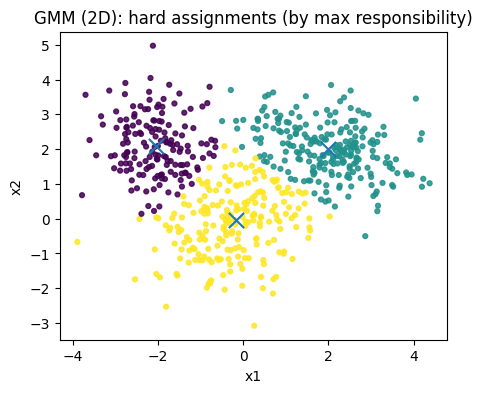

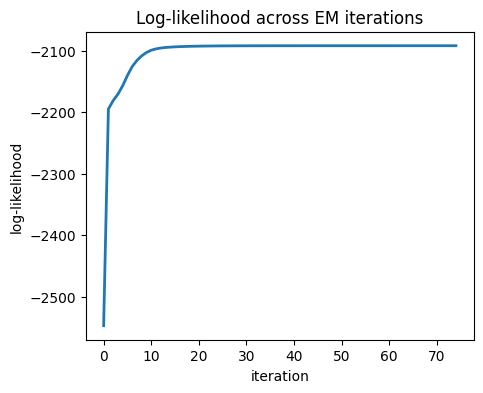

In [36]:

resp = res["resp"]
labels = np.argmax(resp, axis=1)

plt.figure(figsize=(5,4))
plt.scatter(X[:,0], X[:,1], c=labels, s=12, alpha=0.85)
plt.scatter(res["means"][:,0], res["means"][:,1], s=120, marker="x")
plt.title("GMM (2D): hard assignments (by max responsibility)")
plt.xlabel("x1"); plt.ylabel("x2")
plt.show()

plt.figure(figsize=(5,4))
plt.plot(res["ll_trace"], lw=2)
plt.title("Log-likelihood across EM iterations")
plt.xlabel("iteration"); plt.ylabel("log-likelihood")
plt.show()



## 3. EM for a Mixture of Coins

We have $N$ experiments; each experiment tosses an unknown coin $m$ times and observes $x_i$ heads.
Two coins A and B with unknown biases $\theta_A,\theta_B$; mixing probability $\pi=P(Z_i=A)$.

E-step:
$
r_i = P(Z_i=A \mid x_i)
= \frac{ \pi \cdot \binom{m}{x_i}\theta_A^{x_i}(1-\theta_A)^{m-x_i} }{\pi \cdot \binom{m}{x_i}\theta_A^{x_i}(1-\theta_A)^{m-x_i} + (1-\pi)\cdot \binom{m}{x_i}\theta_B^{x_i}(1-\theta_B)^{m-x_i}}.
$

M-step:
$
\pi \leftarrow \frac{1}{N}\sum_i r_i,\quad
\theta_A \leftarrow \frac{\sum_i r_i x_i}{m \sum_i r_i},\quad
\theta_B \leftarrow \frac{\sum_i (1-r_i) x_i}{m \sum_i (1-r_i)}.
$


In [37]:

def generate_coin_data(N=50, m=10, theta_A=0.7, theta_B=0.4, pi=0.6, seed=0):
    rng = np.random.default_rng(seed)
    Z = rng.random(N) < pi  # True if A, False if B
    X = np.zeros(N, dtype=int)
    for i in range(N):
        th = theta_A if Z[i] else theta_B
        X[i] = rng.binomial(m, th)
    return X, Z

def em_coin_mixture(X, m, max_iter=200, tol=1e-8, seed=1):
    rng = np.random.default_rng(seed)
    N = len(X)
    pi = 0.5
    theta_A = 0.6
    theta_B = 0.5
    ll_trace = []

    def binom_pmf(x, m, p):
        from math import comb
        return comb(m, x) * (p**x) * ((1-p)**(m-x))

    for it in range(max_iter):
        # E-step
        num = np.array([pi * binom_pmf(x, m, theta_A) for x in X])
        den = num + np.array([(1-pi) * binom_pmf(x, m, theta_B) for x in X])
        r = num / (den + 1e-16)

        # M-step
        pi_new = r.mean()
        theta_A_new = (r @ X) / (m * r.sum() + 1e-16)
        theta_B_new = ((1-r) @ X) / (m * (1-r).sum() + 1e-16)

        # Incomplete-data log-likelihood
        ll = np.sum(np.log(pi * np.array([binom_pmf(x, m, theta_A) for x in X]) +
                           (1-pi) * np.array([binom_pmf(x, m, theta_B) for x in X]) + 1e-16))
        ll_trace.append(float(ll))

        pi, theta_A, theta_B = pi_new, theta_A_new, theta_B_new
        if it > 3 and abs(ll_trace[-1] - ll_trace[-2]) < tol:
            break

    return {"pi": pi, "theta_A": theta_A, "theta_B": theta_B, "ll_trace": ll_trace, "r": r}

# Demo
Xc, Zc = generate_coin_data(N=60, m=12, theta_A=0.75, theta_B=0.45, pi=0.55, seed=7)
res_coin = em_coin_mixture(Xc, m=12, seed=11)
print("Estimated parameters:")
print(f"  pi       = {res_coin['pi']:.3f}")
print(f"  theta_A  = {res_coin['theta_A']:.3f}")
print(f"  theta_B  = {res_coin['theta_B']:.3f}")


Estimated parameters:
  pi       = 0.415
  theta_A  = 0.806
  theta_B  = 0.535


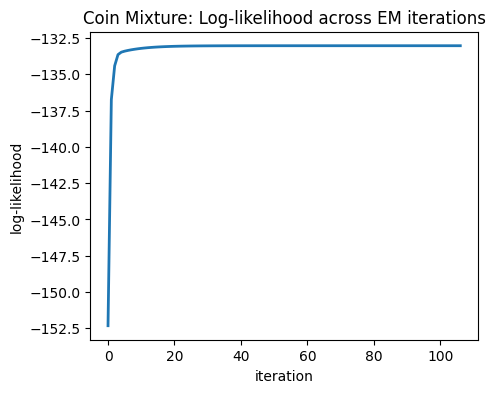

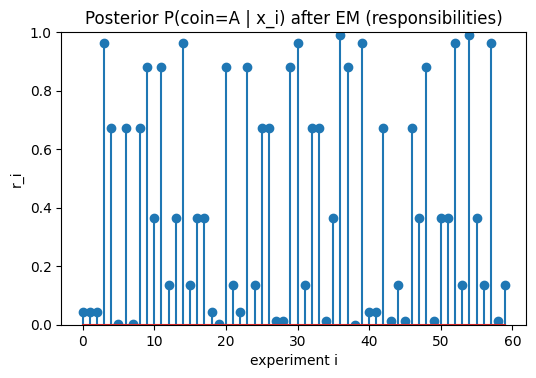

In [25]:

# Visualizations for the coin mixture
plt.figure(figsize=(5,4))
plt.plot(res_coin["ll_trace"], lw=2)
plt.title("Coin Mixture: Log-likelihood across EM iterations")
plt.xlabel("iteration"); plt.ylabel("log-likelihood")
plt.show()

plt.figure(figsize=(6,3.8))
plt.stem(res_coin["r"])
plt.title("Posterior P(coin=A | x_i) after EM (responsibilities)")
plt.xlabel("experiment i"); plt.ylabel("r_i")
plt.ylim(0,1)
plt.show()



## 4. Conclusion

You implemented and visualized EM for two classic models. EM is a powerful method for maximum-likelihood
estimation with latent variables (mixtures, HMMs, factor analyzers, etc.). Try adapting these templates to
your own datasets and models.
